In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import preproccessing as prep
from evaluation import show_scenarios_evaluation
from regime_switching_brownian_motion import RegimeSwitching
from independent_lognormal_model import IndependentLogNormal



In [3]:
def convert_regime_params(params: pd.Series, k):
    """
    params: scipy stats regime params object
    k: number of regimes

    returns annulised params tumple (mean, sigma, transition matrix)
    """
    mu = np.zeros(k)
    sigmas = np.zeros(k)
    transition_matrix = np.zeros((k,k))
    
    for i in range (k):
        mu[i] = params[f'const[{i}]']
        sigmas[i] = np.sqrt(params[f'sigma2[{i}]'])
        
    for i in range(k):
        for j in range(k-1):
            transition_matrix[i,j] = params[f'p[{i}->{j}]']

    transition_matrix[:,-1] = 1 - transition_matrix.sum(axis=1)

            
    return mu, sigmas, transition_matrix

def params_summary(mus,sigmas,transition_matrix,current_regime):
    print('mus: ')
    print(mus * 12)
    print('sigmas: ')
    print(sigmas * np.sqrt(12))
    print('transition matrix: ')
    print(transition_matrix)
    print('current_regime: ')
    print(current_regime)

def estimate_markov_regime_switching_params(data,period):
    n_regimes = 2
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True
    )

    result = model.fit() 

    mus, sigmas, transition_matrix = convert_regime_params(result.params, n_regimes)

    current_regime = np.argmax([result.smoothed_marginal_probabilities[0].iloc[-1],result.smoothed_marginal_probabilities[1].iloc[-1]])

    #return {'mus':mus, 'sigmas': sigmas, 'transition_matrix': transition_matrix, 'current_regime': current_regime}
    return mus,sigmas,transition_matrix,current_regime

In [4]:
def show_RSLN_scenarios_evaluation(mus, sigmas, transition_matrix, initial_values, current_regime, dt, n_scenarios, n_steps, hist):
    
    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mus[0],sigma=[sigmas[0]]),
            IndependentLogNormal(mu=mus[1],sigma=[sigmas[1]])],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)

def convert_to_transition_matrix(p00,p10):
     k =2
     transition_matrix = np.zeros((k,k))
     transition_matrix[0,0] = p00
     transition_matrix[1,0] = p10
     transition_matrix[:,1] = 1 - transition_matrix[:,0]
     return transition_matrix

In [5]:
#'acwi_25.08.23.csv' - curvo file
acwi = pd.read_excel('acwi_usd_net_31.11.23.xlsx',index_col='Date', parse_dates=True)
acwi = acwi.squeeze()
acwi = (acwi+1).cumprod()
acwi.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 430 entries, 1988-01-29 to 2023-10-31
Series name: ACWI
Non-Null Count  Dtype  
--------------  -----  
430 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


<AxesSubplot:xlabel='Date'>

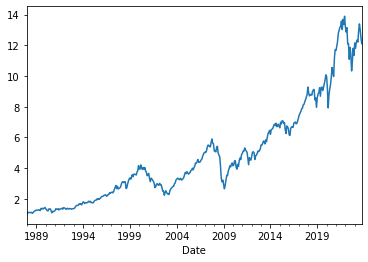

In [6]:
acwi.plot()

In [14]:
acwi_returns = prep.log_returns(acwi)

periods = [('1988-01-01', '2023-10-31'),
           ('2003-01-01', '2023-10-31'),
           ('1989-12-01', '2023-07-31'),
           ('1989-12-01', '2019-12-31'),
           ('2007-10-01', '2023-07-31'),               
           ('1999-01-01', '2023-10-31'), 
           ('2003-01-01', '2023-10-31'),                       
           ('2000-03-01', '2023-07-31'),
           ('2002-09-01', '2022-09-30'),
           ('2002-09-01', '2020-03-31'),
           ]
           

prep.asset_stats(acwi_returns, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1988-01-01, 2023-10-31)",0.069067,0.153773,-0.785235,1.978242,0.880075,-0.549231
"(2003-01-01, 2023-10-31)",0.077396,0.156670,-0.939333,2.822137,1.047969,-0.549231
"(1989-12-01, 2023-07-31)",0.067090,0.155137,-0.827014,1.998269,0.828205,-0.549231
"(1989-12-01, 2019-12-31)",0.065635,0.150360,-0.888050,2.385491,0.820990,-0.549231
"(2007-10-01, 2023-07-31)",0.054167,0.171064,-0.873204,2.180193,0.489388,-0.549231
"(1999-01-01, 2023-10-31)",0.052303,0.159247,-0.801046,1.970217,0.485163,-0.549231
"(2003-01-01, 2023-10-31)",0.077396,0.156670,-0.939333,2.822137,1.047969,-0.549231
"(2000-03-01, 2023-07-31)",0.052099,0.160782,-0.833355,2.023188,0.476123,-0.549231
"(2002-09-01, 2022-09-30)",0.070303,0.159649,-0.976021,2.735161,0.874514,-0.549231
"(2002-09-01, 2020-03-31)",0.065229,0.156786,-1.138869,3.370436,0.778376,-0.549231


In [8]:

data = acwi_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1988-01-01, 2023-11-30)",94.26,5.83,1.30,-0.16,0.06,0.32
"(2003-01-01, 2023-11-30)",94.15,6.88,1.35,-0.23,0.06,0.37
"(1989-12-01, 2023-07-31)",94.16,5.89,1.33,-0.23,0.06,0.33
"(1989-12-01, 2019-12-31)",95.33,5.27,1.29,-0.29,0.06,0.32
"(2007-10-01, 2023-07-31)",90.46,8.35,1.34,-0.33,0.05,0.40
"(2000-03-01, 2023-07-31)",94.53,4.82,1.38,-0.43,0.05,0.34
"(2002-09-01, 2022-09-30)",93.88,7.10,1.37,-0.43,0.05,0.40
"(2002-09-01, 2020-03-31)",94.27,8.13,1.34,-0.76,0.06,0.42


In [9]:
usdpln = prep.loadStooqData('usdpln','1998-12-01','d')
usdpln = usdpln.resample('BM').last()
usdpln_ret = prep.log_returns(usdpln)
acwi_pln = (acwi * usdpln).dropna()
acwi_pln_returns = prep.log_returns(acwi_pln)
prep.assets_performance(acwi_pln_returns['2000-01-01':])

Annualised Mean     0.045560
Annualised Sigma    0.131422
Skew               -0.474654
Kurtosis            0.605922
Sharp_ratio         0.410138
Max drowdawn       -0.501503
dtype: float64

<AxesSubplot:>

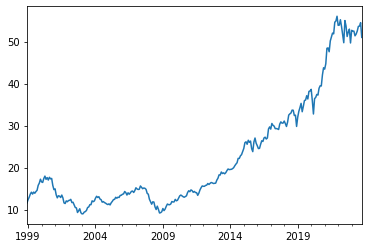

In [10]:
acwi_pln.plot()

In [16]:
periods = [('1999-01-01', '2023-10-31'), 
           ('2003-01-01', '2023-10-31'),                       
           ('2000-03-01', '2023-07-31'),
           ('2002-09-01', '2022-09-30'),
           ('2002-09-01', '2020-03-31'),
           ]
prep.asset_stats(acwi_pln_returns, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1999-01-01, 2023-10-31)",0.059710,0.132053,-0.479533,0.553699,0.779377,-0.501503
"(2003-01-01, 2023-10-31)",0.081994,0.121580,-0.293625,0.694741,1.481428,-0.412454
"(2000-03-01, 2023-07-31)",0.050466,0.131453,-0.487706,0.640260,0.539327,-0.501503
"(2002-09-01, 2022-09-30)",0.079423,0.126471,-0.428941,0.878068,1.353708,-0.412454
"(2002-09-01, 2020-03-31)",0.065291,0.124621,-0.637386,0.894812,0.980985,-0.412454


In [17]:
data = acwi_pln_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1999-01-01, 2023-10-31)",95.48,10.99,1.26,-1.38,0.08,0.27
"(2003-01-01, 2023-10-31)",95.75,13.79,1.13,-0.82,0.07,0.27
"(2000-03-01, 2023-07-31)",95.60,9.90,1.18,-1.28,0.07,0.27
"(2002-09-01, 2022-09-30)",95.77,12.04,1.18,-1.07,0.07,0.31
"(2002-09-01, 2020-03-31)",96.24,11.10,1.10,-1.53,0.07,0.30


Sample paths


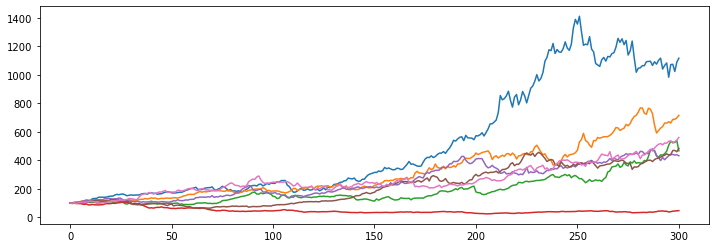

None
Fanchart


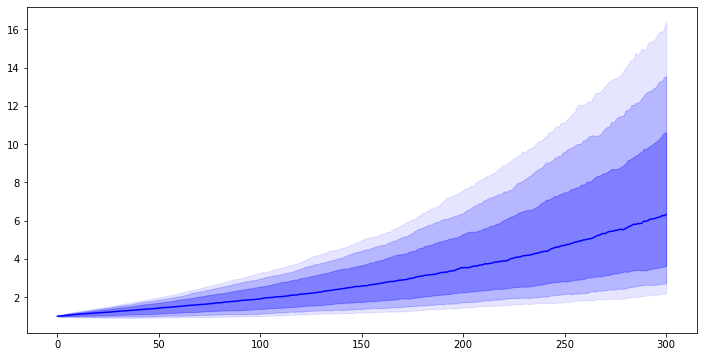

None
Percentaile summary


,12,36,60,120,240,300
10,0.934620,0.913235,0.934242,1.089873,1.701706,2.202388
15,0.974934,0.980333,1.025654,1.244252,2.020470,2.720112
25,1.025582,1.095363,1.187183,1.512518,2.683975,3.626426
50,1.117066,1.299205,1.512844,2.151131,4.388564,6.315760
75,1.201341,1.508781,1.860315,2.976627,6.991614,10.612341
85,1.244387,1.612000,2.031885,3.478574,8.935471,13.538626
90,1.276139,1.702491,2.197672,3.828375,10.359945,16.408964


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.072478,0.129632,-0.571904,1.886944,1.183561,-0.391244
std,0.031709,0.010733,0.289005,0.963643,0.910060,0.126540
min,-0.045936,0.097245,-1.914039,-0.211697,-1.727848,-0.867518
25%,0.051530,0.122444,-0.758250,1.273698,0.560470,-0.472451
50%,0.073722,0.129478,-0.574848,1.734976,1.170345,-0.371962
75%,0.094481,0.137104,-0.381024,2.318865,1.770575,-0.299383
max,0.167042,0.167199,0.604224,11.654633,4.143541,-0.127427


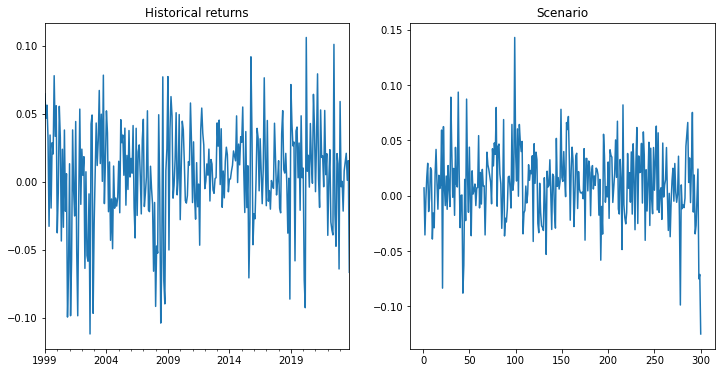

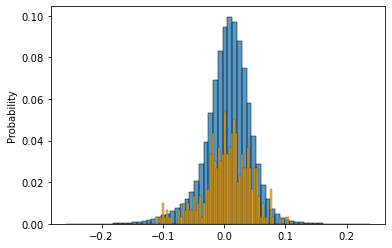

In [20]:
transition_matrix = convert_to_transition_matrix(95.77/100,12.04/100)

mus = [ 0.0118, -0.0107]
sigmas = np.sqrt([0.0007, 0.0031])

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_pln_returns)

5,7.2,9.6

### porownanie
regime switching 1990-2013:  
params .. 
curretirns percentile  
|1 | 2 | 3 |
| .. | ... | ... |  
assets stats 